In [ ]:
#dataset link
#https://drive.google.com/drive/folders/1IB30n-VIPByRIccrG9BhkWd7pp0naged?usp=sharing

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50
PATCH_SIZE = 16

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2172 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 0 1 0 1 2 0 0 1 2 0 1 1 0 0 0 0 1 0 1 2 1 0 0 1 0 1 1 1 1 0]


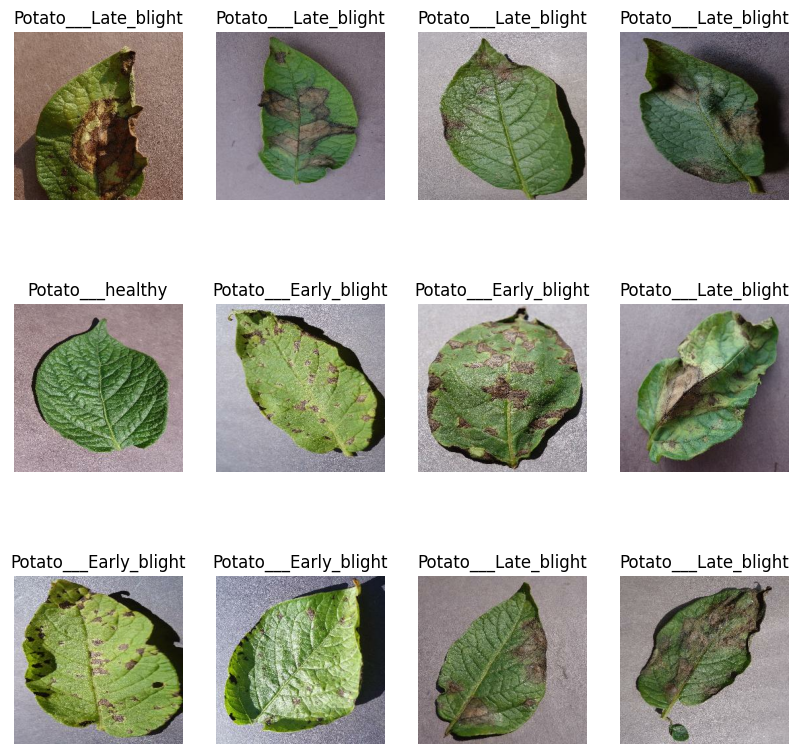

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

68

In [ ]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [ ]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.GaussianNoise(0.1)

])


In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded


In [ ]:
def create_vit_classifier(image_size, patch_size, num_patches, projection_dim, transformer_units, num_heads, mlp_head_units, num_classes):
    inputs = layers.Input(shape=(image_size, image_size, CHANNELS))

    # Create patches and encode them
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Transformer block
    for _ in range(8):  # Number of transformer layers
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Multi-head attention layer
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP (Feed-forward network)
        x3 = layers.Dense(transformer_units, activation=tf.nn.gelu)(x3)
        x3 = layers.Dense(projection_dim)(x3)
        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # MLP head
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dense(mlp_head_units, activation=tf.nn.gelu)(representation)
    outputs = layers.Dense(num_classes, activation='softmax')(representation)

    # Create the Keras model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# Set parameters for ViT
projection_dim = 64
transformer_units = 128
num_heads = 4
mlp_head_units = 128

# Calculate number of patches
num_patches = (IMAGE_SIZE // PATCH_SIZE) ** 2

# Number of classes
num_classes = 3

# Create the ViT model
vit_model = create_vit_classifier(
    IMAGE_SIZE, PATCH_SIZE, num_patches, projection_dim,
    transformer_units, num_heads, mlp_head_units, num_classes
)


In [ ]:
# Compile the model
vit_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
# Summary of the model
vit_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 patches (Patches)           (None, None, 768)            0         ['input_1[0][0]']             
                                                                                                  
 patch_encoder (PatchEncode  (None, 256, 64)              65600     ['patches[0][0]']             
 r)                                                                                               
                                                                                                  
 layer_normalization (Layer  (None, 256, 64)              128       ['patch_encoder[0][0]']   

In [ ]:
# Train the model
history = vit_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/50
54/54 [==============================] - 103s 1s/step - loss: 4.7406 - accuracy: 0.4578 - val_loss: 0.8766 - val_accuracy: 0.5104
Epoch 2/50
54/54 [==============================] - 68s 1s/step - loss: 0.9080 - accuracy: 0.4850 - val_loss: 0.8438 - val_accuracy: 0.5104
Epoch 3/50
54/54 [==============================] - 66s 1s/step - loss: 0.8867 - accuracy: 0.5064 - val_loss: 0.8276 - val_accuracy: 0.5833
Epoch 4/50
54/54 [==============================] - 64s 1s/step - loss: 0.8586 - accuracy: 0.5822 - val_loss: 0.9688 - val_accuracy: 0.4375
Epoch 5/50
54/54 [==============================] - 62s 1s/step - loss: 0.8492 - accuracy: 0.5613 - val_loss: 0.7606 - val_accuracy: 0.7292
Epoch 6/50
54/54 [==============================] - 63s 1s/step - loss: 0.7570 - accuracy: 0.6591 - val_loss: 0.6631 - val_accuracy: 0.7812
Epoch 7/50
54/54 [==============================] - 64s 1s/step - loss: 0.6632 - accuracy: 0.7141 - val_loss: 0.8193 - val_accuracy: 0.5833
Epoch 8/50
54/54 [=

In [ ]:
# Evaluate the model on test set
test_loss, test_acc = vit_model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc}")


8/8 [==============================] - 7s 440ms/step - loss: 0.1216 - accuracy: 0.9570
Test Accuracy: 0.95703125


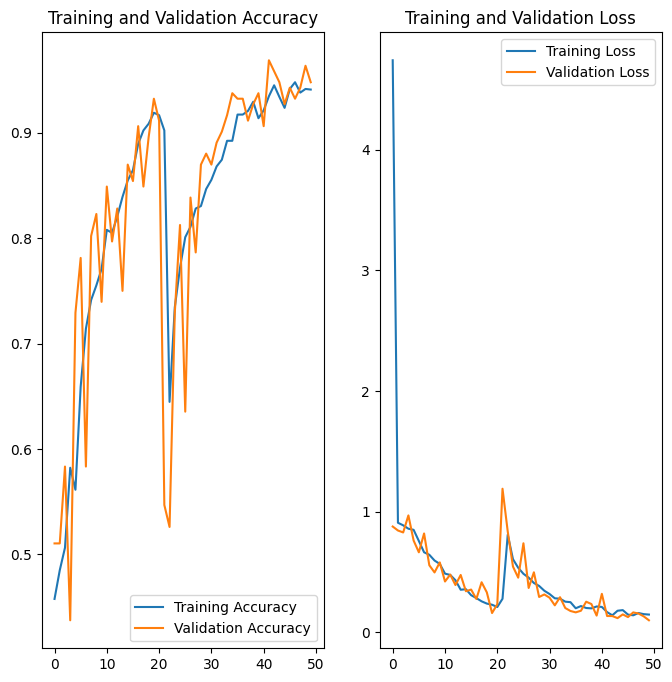

In [ ]:
# Plot training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Save the trained model in h5 format
vit_model.save('vit_potato_classifier.h5')
